# **AI-Powered Student Subject Allocation System: A Machine Learning Approach**

This notebook presents the implementation of two machine learning models designed for automatically assigning students to advanced course combinations based on their academic performance and aspirations. 

- **Model 1**: A simple neural network without optimizations, serving as a baseline.
- **Model 2**: A neural network incorporating optimization techniques such as L1/L2 regularization and various optimizers (Adam, RMSProp).
  
The notebook also includes data preprocessing, feature engineering (for the custom `Adv_course_combination` feature), model training, and evaluation metrics like confusion matrix, precision, F1 score, and specificity.

The goal is to demonstrate how optimizations improve model performance and generalization for this multi-class classification task.

--- 


## Importing necessary libraries

In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler


## Load the data

In [348]:
data = pd.read_csv('student-scores.csv')
data.head()

,id,first_name,last_name,email,gender,part_time_job,absence_days,extracurricular_activities,weekly_self_study_hours,career_aspiration,math_score,history_score,physics_score,chemistry_score,biology_score,english_score,geography_score
0,1,Paul,Casey,paul.casey.1@gslingacademy.com,male,False,3,False,27,Lawyer,73,81,93,97,63,80,87
1,2,Danielle,Sandoval,danielle.sandoval.2@gslingacademy.com,female,False,2,False,47,Doctor,90,86,96,100,90,88,90
2,3,Tina,Andrews,tina.andrews.3@gslingacademy.com,female,False,9,True,13,Government Officer,81,97,95,96,65,77,94
3,4,Tara,Clark,tara.clark.4@gslingacademy.com,female,False,5,False,3,Artist,71,74,88,80,89,63,86
4,5,Anthony,Campos,anthony.campos.5@gslingacademy.com,male,False,5,False,10,Unknown,84,77,65,65,80,74,76


In [349]:
data.duplicated().sum()

0

In [350]:
data.describe()

,id,absence_days,weekly_self_study_hours,math_score,history_score,physics_score,chemistry_score,biology_score,english_score,geography_score
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000
mean,1000.500000,3.665500,17.755500,83.452000,80.332000,81.336500,79.995000,79.58150,81.277500,80.888000
std,577.494589,2.629271,12.129604,13.224906,12.736046,12.539453,12.777895,13.72219,12.027087,11.637705
min,1.000000,0.000000,0.000000,40.000000,50.000000,50.000000,50.000000,30.00000,50.000000,60.000000
25%,500.750000,2.000000,5.000000,77.000000,69.750000,71.000000,69.000000,69.00000,72.000000,71.000000
50%,1000.500000,3.000000,18.000000,87.000000,82.000000,83.000000,81.000000,81.00000,83.000000,81.000000
75%,1500.250000,5.000000,28.000000,93.000000,91.000000,92.000000,91.000000,91.00000,91.000000,91.000000
max,2000.000000,10.000000,50.000000,100.000000,100.000000,100.000000,100.000000,100.00000,99.000000,100.000000


## Feature Engineering

In [351]:
def assign_combination(row):
    if (row['physics_score'] >= 50 and row['chemistry_score'] >= 50 and row['biology_score'] >= 50 and
            row['career_aspiration'].lower() in ['doctor', 'teacher', 'scientist']):
        return 'PCB'
    elif (row['physics_score'] >= 50 and row['chemistry_score'] >= 50 and row['math_score'] >= 50 and
          row['career_aspiration'].lower() in ['software engineer', 'game developer', 'banker', 'accountant', 'sotck investor', 'teacher', 'government officer']):
        return 'PCM'
    elif (row['math_score'] >= 50 and row['physics_score'] >= 50 and row['geography_score'] >= 50 and
          row['career_aspiration'].lower() in ['construction engineer', 'software engineer', 'game developer', 'banker', 'accountant', 'stock investor', 'teacher', 'government officer', 'unknown', 'business owner', 'banker', 'real estate developer']):
        return 'MPG'
    elif (row['history_score'] >= 50 and row['english_score'] >= 50 and row['geography_score'] >= 50 and
          row['career_aspiration'].lower() in ['teacher', 'business owner', 'lawyer', 'artist', 'unknown']):
        return 'HEG'
    elif row['math_score'] < 50 and row['physics_score'] < 50:
        return 'HEG'
    elif row['math_score'] or row['physics_score'] or row['geography_score'] or row['chemistry_score'] < 50:
        return 'HEG'
    else:
        return 'None'


data['Adv_course_combination'] = data.apply(assign_combination, axis=1)
data.head()

,id,first_name,last_name,email,gender,part_time_job,absence_days,extracurricular_activities,weekly_self_study_hours,career_aspiration,math_score,history_score,physics_score,chemistry_score,biology_score,english_score,geography_score,Adv_course_combination
0,1,Paul,Casey,paul.casey.1@gslingacademy.com,male,False,3,False,27,Lawyer,73,81,93,97,63,80,87,HEG
1,2,Danielle,Sandoval,danielle.sandoval.2@gslingacademy.com,female,False,2,False,47,Doctor,90,86,96,100,90,88,90,PCB
2,3,Tina,Andrews,tina.andrews.3@gslingacademy.com,female,False,9,True,13,Government Officer,81,97,95,96,65,77,94,PCM
3,4,Tara,Clark,tara.clark.4@gslingacademy.com,female,False,5,False,3,Artist,71,74,88,80,89,63,86,HEG
4,5,Anthony,Campos,anthony.campos.5@gslingacademy.com,male,False,5,False,10,Unknown,84,77,65,65,80,74,76,MPG


In [352]:
num_pcb = (data['Adv_course_combination'] == 'PCB').sum()
num_mpg = (data['Adv_course_combination'] == 'MPG').sum()
num_pcm = (data['Adv_course_combination'] == 'PCM').sum()
num_heg = (data['Adv_course_combination'] == 'HEG').sum()
num_none = (data['Adv_course_combination'] == 'None').sum()
total_num = num_none + num_heg + num_mpg + num_pcb + num_pcm

print(f'Total number of students are: {total_num}\n')
print(f'Number of students in PCB: {num_pcb}')
print(f'Number of students in MPG: {num_mpg}')
print(f'Number of students in PCM: {num_pcm}')
print(f'Number of students in HEG: {num_heg}')
print(f'Number of students without a combination: {num_none}')

Total number of students are: 2000

Number of students in PCB: 217
Number of students in MPG: 706
Number of students in PCM: 734
Number of students in HEG: 343
Number of students without a combination: 0


## Prepare features and target

In [353]:
X = data[['math_score', 'history_score', 'physics_score',
          'chemistry_score', 'biology_score', 'english_score', 'geography_score']]
y = pd.get_dummies(data['Adv_course_combination'])


## Split the data

In [354]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## Scale the features

In [355]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Helper functions for model evaluation

In [356]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(122)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [357]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test.values, axis=1)

    print(classification_report(y_test_classes,
          y_pred_classes, target_names=y.columns))

    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=y.columns, yticklabels=y.columns)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(f"F1 Score: {f1_score(y_test_classes,
          y_pred_classes, average='weighted')}")


## Model 1: Simple Neural Network (without optimization)

/home/maxime-guy/anaconda3/envs/runpython/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Simple Model Evaluation:


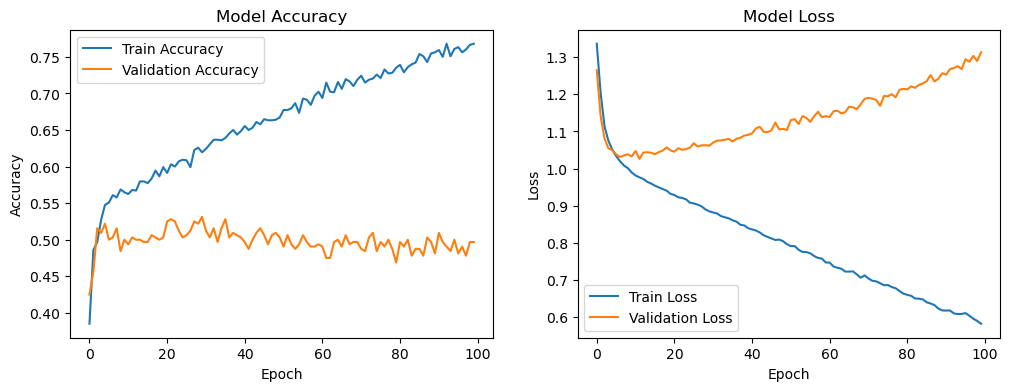

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

         HEG       0.34      0.28      0.30        69
         MPG       0.55      0.44      0.49       148
         PCB       0.42      0.51      0.46        51
         PCM       0.44      0.54      0.48       132

    accuracy                           0.45       400
   macro avg       0.44      0.44      0.43       400
weighted avg       0.46      0.45      0.45       400



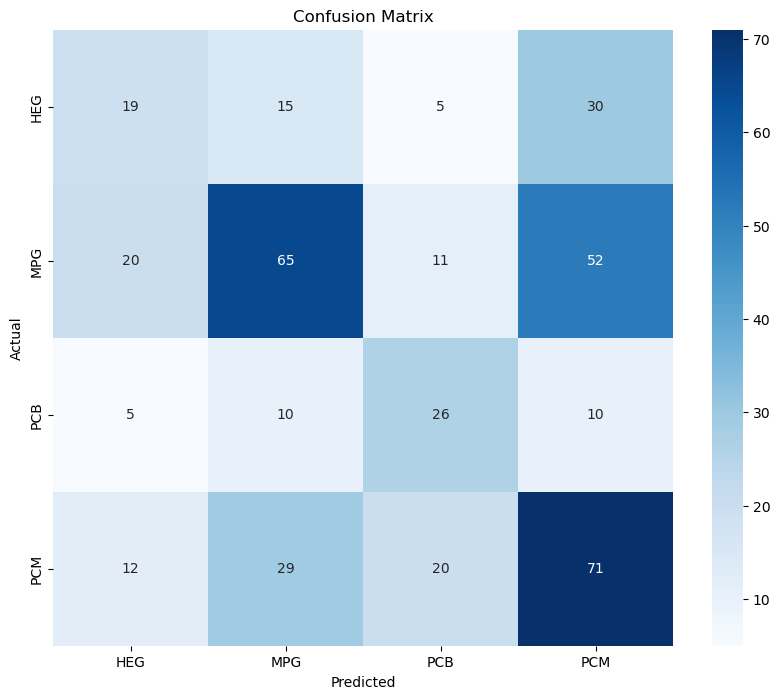

F1 Score: 0.45010983673288246


In [410]:
def create_simple_model(input_shape, output_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model


simple_model = create_simple_model(X_train.shape[1], y_train.shape[1])
simple_history = simple_model.fit(
    X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

print("Simple Model Evaluation:")
plot_history(simple_history)
evaluate_model(simple_model, X_test_scaled, y_test)

## Model 2: Optimized Models

### L1 with Adam

/home/maxime-guy/anaconda3/envs/runpython/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



L1 with Adam Model Evaluation:


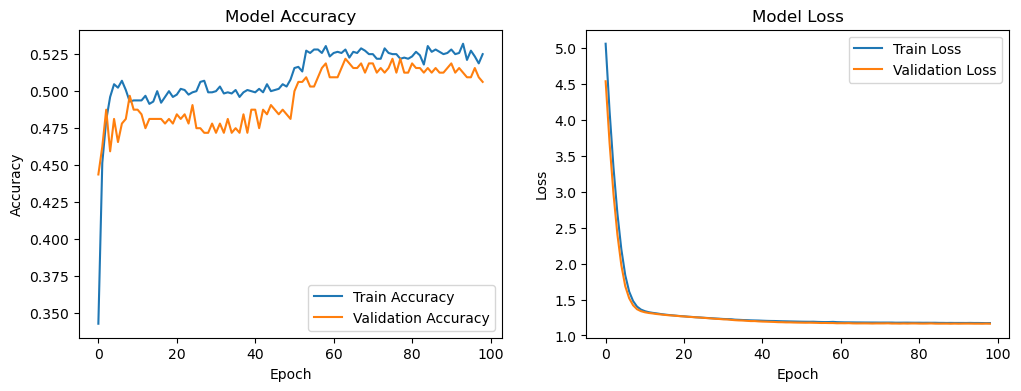

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

         HEG       0.44      0.06      0.10        69
         MPG       0.57      0.51      0.54       148
         PCB       0.43      0.51      0.47        51
         PCM       0.47      0.70      0.56       132

    accuracy                           0.49       400
   macro avg       0.48      0.44      0.42       400
weighted avg       0.50      0.49      0.46       400



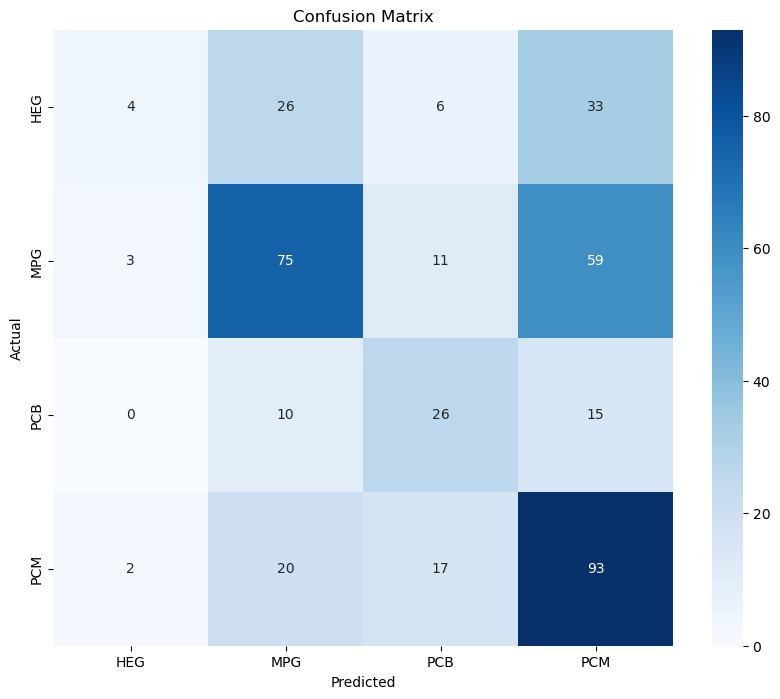

F1 Score: 0.4612262866771222


In [407]:
def create_l1_adam_model(input_shape, output_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(
            input_shape,), kernel_regularizer=l1(0.01)),
        Dense(32, activation='relu', kernel_regularizer=l1(0.01)),
        Dense(16, activation='relu', kernel_regularizer=l1(0.01)),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model


l1_adam_model = create_l1_adam_model(X_train.shape[1], y_train.shape[1])
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
l1_adam_history = l1_adam_model.fit(X_train_scaled, y_train, epochs=100,
                                    batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

print("\nL1 with Adam Model Evaluation:")
plot_history(l1_adam_history)
evaluate_model(l1_adam_model, X_test_scaled, y_test)

### L1 with RMSprop

/home/maxime-guy/anaconda3/envs/runpython/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



L1 with RMSprop Model Evaluation:


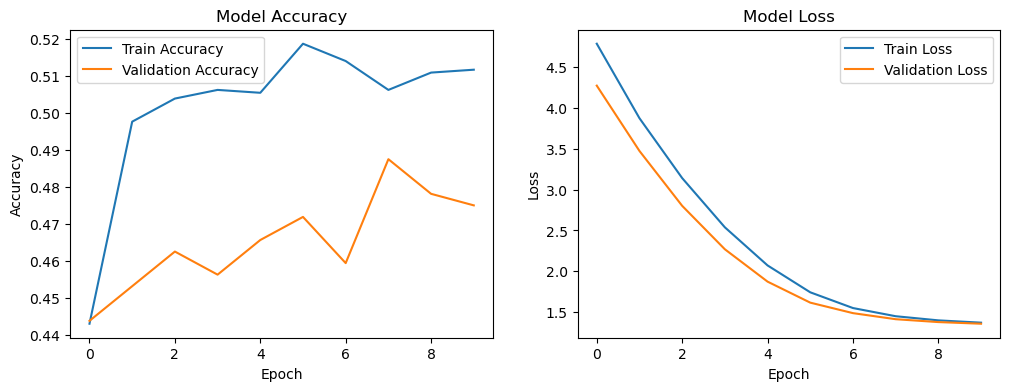

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

         HEG       0.00      0.00      0.00        69
         MPG       0.58      0.49      0.53       148
         PCB       0.00      0.00      0.00        51
         PCM       0.38      0.80      0.52       132

    accuracy                           0.45       400
   macro avg       0.24      0.32      0.26       400
weighted avg       0.34      0.45      0.37       400



/home/maxime-guy/anaconda3/envs/runpython/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/maxime-guy/anaconda3/envs/runpython/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/maxime-guy/anaconda3/envs/runpython/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

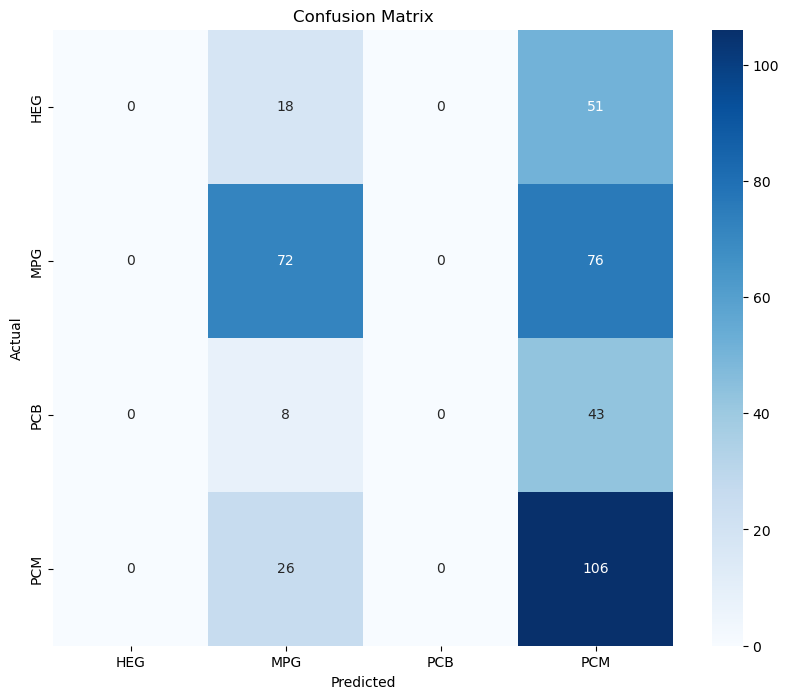

F1 Score: 0.3673529411764706


In [394]:
def create_l1_rmsprop_model(input_shape, output_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(
            input_shape,), kernel_regularizer=l1(0.01)),
        Dense(32, activation='relu', kernel_regularizer=l1(0.01)),
        Dense(16, activation='relu', kernel_regularizer=l1(0.01)),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model


l1_rmsprop_model = create_l1_rmsprop_model(X_train.shape[1], y_train.shape[1])
l1_rmsprop_history = l1_rmsprop_model.fit(
    X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

print("\nL1 with RMSprop Model Evaluation:")
plot_history(l1_rmsprop_history)
evaluate_model(l1_rmsprop_model, X_test_scaled, y_test)

### L2 with Adam

/home/maxime-guy/anaconda3/envs/runpython/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



L2 with Adam Model Evaluation:


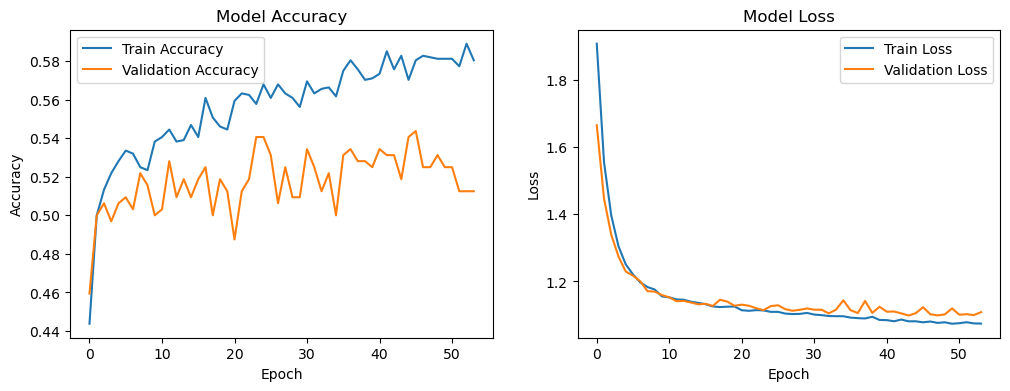

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

         HEG       0.48      0.20      0.29        69
         MPG       0.65      0.51      0.57       148
         PCB       0.54      0.37      0.44        51
         PCM       0.46      0.77      0.58       132

    accuracy                           0.53       400
   macro avg       0.53      0.46      0.47       400
weighted avg       0.55      0.53      0.51       400



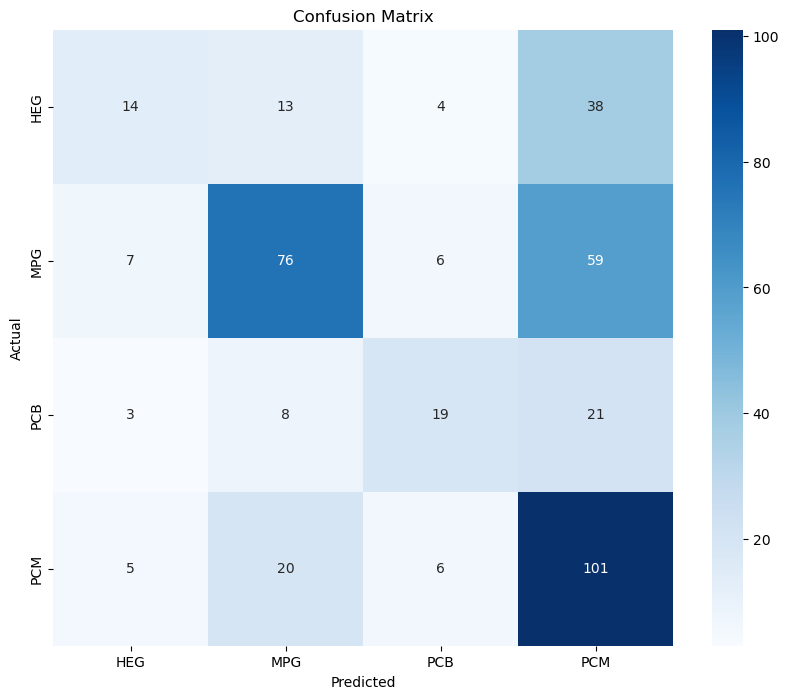

F1 Score: 0.5077638685969095


In [361]:
def create_l2_adam_model(input_shape, output_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(
            input_shape,), kernel_regularizer=l2(0.01)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.002),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model


l2_adam_model = create_l2_adam_model(X_train.shape[1], y_train.shape[1])
l2_adam_history = l2_adam_model.fit(X_train_scaled, y_train, epochs=100,
                                    batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

print("\nL2 with Adam Model Evaluation:")
plot_history(l2_adam_history)
evaluate_model(l2_adam_model, X_test_scaled, y_test)

### L2 with Adam and Learning Rate Scheduler

/home/maxime-guy/anaconda3/envs/runpython/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



L2 with Adam and Learning Rate Scheduler Model Evaluation:


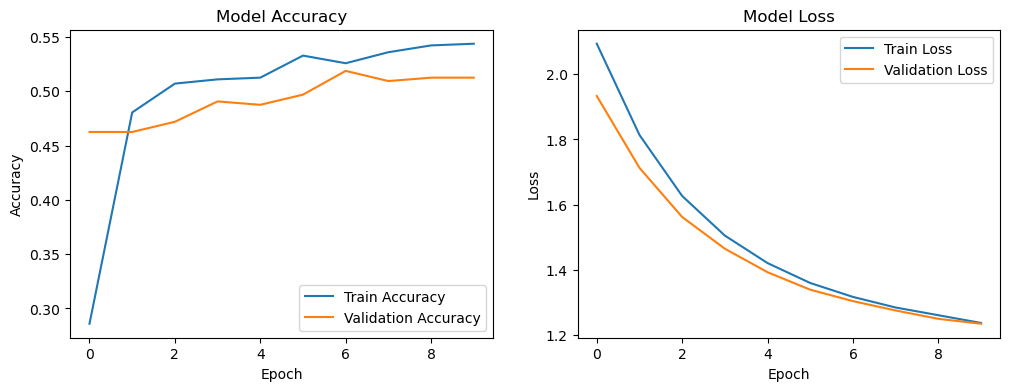

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

         HEG       0.35      0.23      0.28        69
         MPG       0.45      0.63      0.53       148
         PCB       0.50      0.08      0.14        51
         PCM       0.45      0.48      0.47       132

    accuracy                           0.44       400
   macro avg       0.44      0.36      0.35       400
weighted avg       0.44      0.44      0.41       400



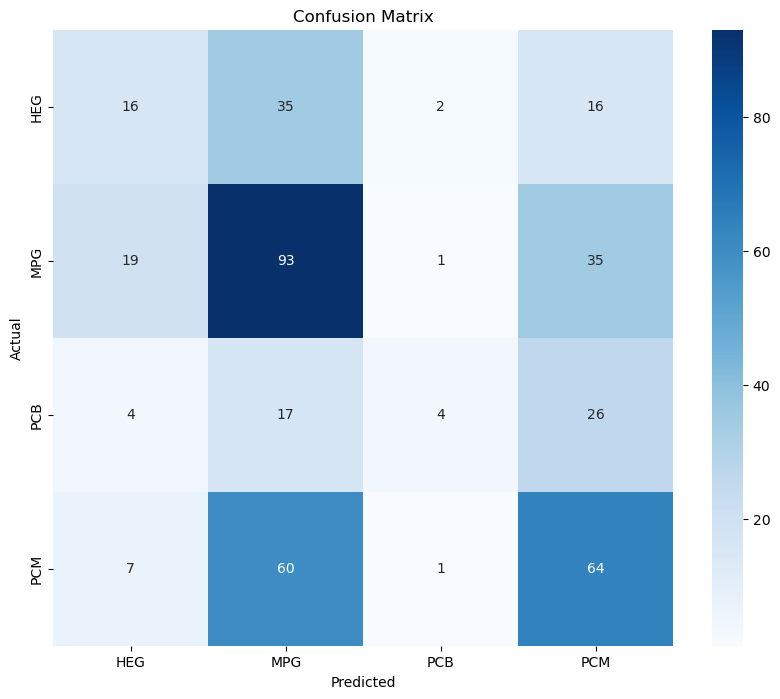

F1 Score: 0.414970917400648


In [383]:
def lr_schedule(epoch):
    return 0.001 * (0.1 ** int(epoch / 10))


def create_l2_adam_lr_model(input_shape, output_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(
            input_shape,), kernel_regularizer=l2(0.01)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model


l2_adam_lr_model = create_l2_adam_lr_model(X_train.shape[1], y_train.shape[1])
lr_scheduler = LearningRateScheduler(lr_schedule)
l2_adam_lr_history = l2_adam_lr_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[
                                          early_stopping, lr_scheduler], verbose=0)

print("\nL2 with Adam and Learning Rate Scheduler Model Evaluation:")
plot_history(l2_adam_lr_history)
evaluate_model(l2_adam_lr_model, X_test_scaled, y_test)

### L2 with RMSprop

/home/maxime-guy/anaconda3/envs/runpython/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



L2 with RMSprop Model Evaluation:


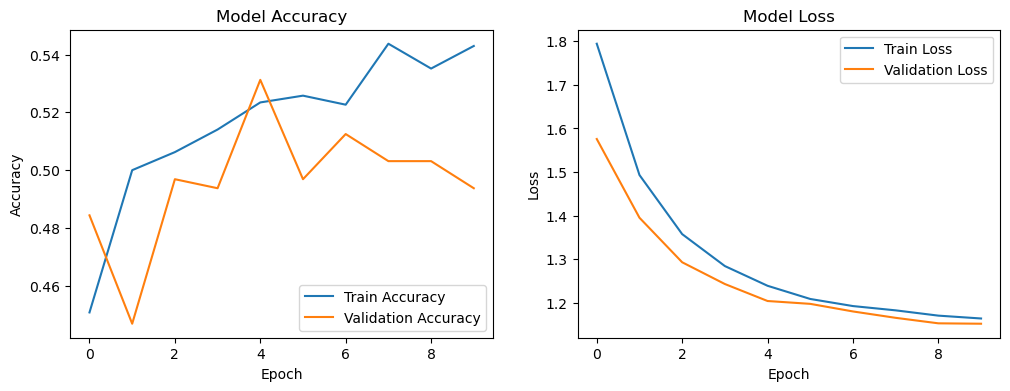

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

         HEG       0.00      0.00      0.00        69
         MPG       0.56      0.49      0.52       148
         PCB       0.00      0.00      0.00        51
         PCM       0.42      0.86      0.56       132

    accuracy                           0.47       400
   macro avg       0.24      0.34      0.27       400
weighted avg       0.34      0.47      0.38       400



/home/maxime-guy/anaconda3/envs/runpython/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/maxime-guy/anaconda3/envs/runpython/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/maxime-guy/anaconda3/envs/runpython/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

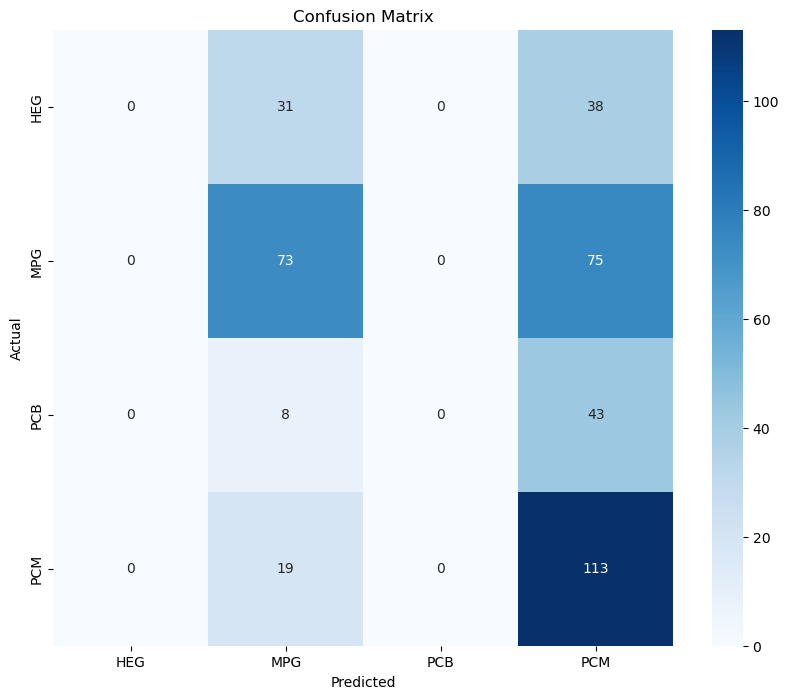

F1 Score: 0.37960510909107165


In [376]:
def create_l2_rmsprop_model(input_shape, output_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(
            input_shape,), kernel_regularizer=l2(0.01)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer=RMSprop(learning_rate=0.002),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model


l2_rmsprop_model = create_l2_rmsprop_model(X_train.shape[1], y_train.shape[1])
l2_rmsprop_history = l2_rmsprop_model.fit(
    X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

print("\nL2 with RMSprop Model Evaluation:")
plot_history(l2_rmsprop_history)
evaluate_model(l2_rmsprop_model, X_test_scaled, y_test)

## Compare all models

In [411]:
models = {
    'Simple Model': simple_model,
    'L1 with Adam': l1_adam_model,
    'L1 with RMSprop': l1_rmsprop_model,
    'L2 with Adam': l2_adam_model,
    'L2 with Adam and LR Scheduler': l2_adam_lr_model,
    'L2 with RMSprop': l2_rmsprop_model
}

for name, model in models.items():
    _, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"{name} - Test Accuracy: {accuracy:.4f}")

Simple Model - Test Accuracy: 0.4525
L1 with Adam - Test Accuracy: 0.4950
L1 with RMSprop - Test Accuracy: 0.4450
L2 with Adam - Test Accuracy: 0.5250
L2 with Adam and LR Scheduler - Test Accuracy: 0.4425
L2 with RMSprop - Test Accuracy: 0.4650


## Save the models

### Save all models

In [412]:
for name, model in models.items():
    model.save(f'saved_models/{name.replace(" ", "_").lower()}.h5')
    print(
        f"Model '{name}' saved as 'saved_models/{name.replace(' ', '_').lower()}.h5'")

Model 'Simple Model' saved as 'saved_models/simple_model.h5'
Model 'L1 with Adam' saved as 'saved_models/l1_with_adam.h5'
Model 'L1 with RMSprop' saved as 'saved_models/l1_with_rmsprop.h5'
Model 'L2 with Adam' saved as 'saved_models/l2_with_adam.h5'
Model 'L2 with Adam and LR Scheduler' saved as 'saved_models/l2_with_adam_and_lr_scheduler.h5'
Model 'L2 with RMSprop' saved as 'saved_models/l2_with_rmsprop.h5'


### Save the best model

In [413]:
best_model_name = max(models, key=lambda x: models[x].evaluate(
    X_test_scaled, y_test, verbose=0)[1])
best_model = models[best_model_name]
best_model.save('saved_models/best_model.h5')
print(
    f"\nBest model ({best_model_name}) saved as 'saved_models/best_model.h5'")


Best model (L2 with Adam) saved as 'saved_models/best_model.h5'
